---
# Linear Classifier

In this assignment, you will build a linear image classifier from scratch in PyTorch. You will implement both the forward and the backward pass of the linear classifier _without_ using PyTorch's autograd capabilities. The notebook is largely adapted (with permission) from https://web.eecs.umich.edu/~justincj/teaching/eecs498/FA2019/assignment2.html.

As in the first assignment, you will see code blocks that look like this:
```python
###############################################################################
# TODO: Create a variable x with value 536.                                   #
###############################################################################
# Replace "pass" statement with your code
pass
# END OF YOUR CODE
```

You should replace the `pass` statement with your own code and leave the blocks intact, like this:
```python
###############################################################################
# TODO: Create a variable x with value 536.                                   #
###############################################################################
# Replace "pass" statement with your code
x = 536
# END OF YOUR CODE
```

Also, please remember:
- Do not write or modify any code outside of code blocks.
- Do not delete any cells from the notebook. You may add new cells to perform scratch work, but delete them before submitting.
- Run all cells before submitting. You will only get credit for code that has been run.
- Submit your notebook as `netid.ipynb`, where `netid` is your actual netid.
- Your submission will be graded with PyTorch 1.7.0 and Python 3.6, which are the default versions in Google Colab.

In [1]:
from __future__ import print_function
from __future__ import division

import math
import time
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

Starting in this assignment, we will use the GPU to accelerate our computation. Run this cell to make sure you are using a GPU.

In [2]:
assert torch.cuda.is_available(), 'GPU unavailable'

## Data Preprocessing

In this assignment, we will be using the CIFAR-10 dataset. It consists of 60K $32 \times 32$ color images in 10 classes, namely: airplanes, automobiles, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6K images in each class, of which 1K are reserved for testing. Image samples and more details are available [here](https://www.cs.toronto.edu/~kriz/cifar.html).

Given an image, our goal here is to predict the class it belongs to. For our linear classifier, we need to flatten the image into a vector. We will also use the **bias trick**: **By adding an extra dimension of constant 1 to the input, we avoid the need to keep track of a separate bias vector.** Specifically, let $W \in \mathbb{R}^{D \times K}$ be a weight matrix, $b \in \mathbb{R}^{K}$ a bias vector, and $x \in \mathbb{R}^{D}$ the input, we have

$$
W^\top x + b =
\begin{bmatrix}
W^\top & b
\end{bmatrix}
\begin{bmatrix}
x\\
1
\end{bmatrix}.
$$

This means we can treat $V^\top := \begin{bmatrix}
W^\top & b
\end{bmatrix}$ as a new weight matrix if we append a constant 1 to the input vector $x$. Therefore, we will represent each CIFAR-10 image as a $32 \times 32 \times 3 + 1 = 3073$ dimensional vector.

In [3]:
def get_CIFAR10_data():
  """
  Load the CIFAR-10 dataset and prepare it for the linear classifier.
  """
  CIFAR10_train = CIFAR10(root='.', train=True, download=True)
  CIFAR10_test = CIFAR10(root='.', train=False, download=True)
  X_train = torch.Tensor(CIFAR10_train.data).permute(0, 3, 1, 2) / 255  # 50K x 3 x 32 x 32
  X_test = torch.Tensor(CIFAR10_test.data).permute(0, 3, 1, 2) / 255  # 10K x 3 x 32 x 32
  y_train = torch.LongTensor(CIFAR10_train.targets)  # 50K
  y_test = torch.LongTensor(CIFAR10_test.targets)  # 10K

  # Normalize the data so that the pixel values have zero mean and unit variance
  RGB_std, RGB_mean = torch.std_mean(X_train, dim=(0, 2, 3), keepdim=True)
  X_train = (X_train - RGB_mean) / RGB_std
  X_test = (X_test - RGB_mean) / RGB_std
  print('RGB_mean:', RGB_mean.squeeze())
  print('RGB_std:', RGB_std.squeeze())

  # Flatten each image into a vector
  X_train = X_train.reshape(X_train.shape[0], -1)
  X_test = X_test.reshape(X_test.shape[0], -1)

  # Bias trick
  ones_train = torch.ones_like(y_train).view(-1, 1)
  ones_test = torch.ones_like(y_test).view(-1, 1)
  X_train = torch.cat([X_train, ones_train], dim=1)
  X_test = torch.cat([X_test, ones_test], dim=1)

  # Carve out part of the training data to use for validation
  num_train = 40000
  torch.manual_seed(0)
  indices = torch.randperm(X_train.shape[0])
  X_val = X_train[indices[num_train:]]
  y_val = y_train[indices[num_train:]]
  X_train = X_train[indices[:num_train]]
  y_train = y_train[indices[:num_train]]

  # Return the dataset as a dictionary
  data_dict = {}
  data_dict['X_train'] = X_train.cuda()
  data_dict['y_train'] = y_train.cuda()
  data_dict['X_val'] = X_val.cuda()
  data_dict['y_val'] = y_val.cuda()
  data_dict['X_test'] = X_test.cuda()
  data_dict['y_test'] = y_test.cuda()
  return data_dict

# Invoke the above function to get our data
data_dict = get_CIFAR10_data()
print('Training data shape:', data_dict['X_train'].shape)
print('Training labels shape:', data_dict['y_train'].shape)
print('Validation data shape:', data_dict['X_val'].shape)
print('Validation labels shape:', data_dict['y_val'].shape)
print('Test data shape:', data_dict['X_test'].shape)
print('Test labels shape:', data_dict['y_test'].shape)

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified
RGB_mean: tensor([0.4914, 0.4822, 0.4465])
RGB_std: tensor([0.2470, 0.2435, 0.2616])
Training data shape: torch.Size([40000, 3073])
Training labels shape: torch.Size([40000])
Validation data shape: torch.Size([10000, 3073])
Validation labels shape: torch.Size([10000])
Test data shape: torch.Size([10000, 3073])
Test labels shape: torch.Size([10000])


## Linear Classifier with Softmax

In this section, we will:

- Implement the loss function for the Softmax classifier.
- Implement the analytic gradient of the loss function.
- Numerically check the gradient.

Let us first consider the case where we are given a single image, already flattened into a vector $x_{(i)} \in \mathbb{R}^{D}$ with $D = 3073$. The corresponding label is $y_{(i)} \in \{0, 1, \dots, K-1\}$ where $K = 10$ is the number of classes. Our linear classifier learns a weight matrix
$$
W = \begin{bmatrix}
\vert &        & \vert  \\
w_0   & \cdots & w_{K-1}\\
\vert &        & \vert
\end{bmatrix} \in \mathbb{R}^{D \times K}
$$
such that
$$
\mathbb{P}(\text{class} = k \mid \text{image} = x_{(i)}) = \frac{\exp{(x_{(i)}^\top w_k)}}{\sum_{j=0}^{K-1} \exp{(x_{(i)}^\top w_j)}}, \quad \text{for each} \ \  k = 0, 1, \dots, K-1.
$$
Here, we treat the image and its class as random variables.

The loss function $\mathcal{L}_{(i)}$ for this single image $x_{(i)}$ is the negative log-likelihood:
$$
\mathcal{L}_{(i)} := -\log \mathbb{P}(y_{(i)} \mid x_{(i)}) := -\log \mathbb{P}(\text{class} = y_{(i)} \mid \text{image} = x_{(i)}).
$$

The training objective is to minimize the negative log-likelihood averaged over all training images, plus some regularization term:
$$
\text{minimize} \quad \mathcal{L}_{N} := \frac{1}{N} \sum_{i=0}^{N-1} \mathcal{L}_{(i)} + \frac{\lambda}{2} \sum_{k=0}^{K-1} \Vert w_k \Vert_2^2,
$$
where $N$ is the number of training images, and $\lambda$ is a hyperparameter controlling regularization strength.

To optimize this objective, we use Stochastic Gradient Descent (SGD). At each optimization step, we will do the following:
- Sample a mini-batch of $B$ training images.
- Compute the loss $\mathcal{L}_{B}$ and the gradient $\frac{\text{d}\mathcal{L}_{B}}{\text{d}W}$ on this mini-batch. Here, $\mathcal{L}_{B}$ can be viewed as an unbiased estimate of $\mathcal{L}_{N}$.
- Update the weights: $W \leftarrow W - \eta \frac{\text{d}\mathcal{L}_{B}}{\text{d}W}$, where $\eta$ is the learning rate.

Now let us implement the loss function $\mathcal{L}_{B}$ and its gradient $\frac{\text{d}\mathcal{L}_{B}}{\text{d}W}$. To take full advantage of GPU acceleration, we would like our implementation to be vectorized, that is, not containing any loops.

We are given a mini-batch of $B$ training images
$$
X = \begin{bmatrix}
\text{—} & x_{(0)}^\top   & \text{—}\\
         & \vdots         &         \\
\text{—} & x_{(B-1)}^\top & \text{—}
\end{bmatrix} \in \mathbb{R}^{B \times D},
$$
and the corresponding labels
$$
y = \begin{bmatrix}
y_{(0)}\\
\vdots \\
y_{(B-1)}
\end{bmatrix} \in \mathbb{R}^{B}.
$$

The vectorized implementation of the loss function $\mathcal{L}_{B}$ is as follows:
- Compute a matrix $O \in \mathbb{R}^{B \times K}$ such that $O[i, k] = x_{(i)}^\top w_k$.
- Compute a matrix $P \in \mathbb{R}^{B \times K}$ from $O$ such that $P[i, k] = \mathbb{P}(\text{class} = k \mid \text{image} = x_{(i)})$.
- Obtain the vector $\begin{bmatrix}
\mathcal{L}_{(0)}\\
\vdots\\
\mathcal{L}_{(B-1)}
\end{bmatrix}$ by computing the negative logarithm of proper elements of $P$.
- Compute the mean of this vector, and add the regularization term.

Please derive the gradient $\frac{\text{d}\mathcal{L}_{B}}{\text{d}W}$ and give a vectorized implementation of the gradient by yourself.

Hint: You need to first compute $-\frac{\partial \log \! P[i, y_{(i)}]}{\partial O[i, j]}$, since

$$
\frac{\partial \mathcal{L}_{(i)}}{\partial w_j}
= -\frac{\partial \log \! P[i, y_{(i)}]}{\partial O[i, j]} \cdot \frac{\partial O[i, j]}{\partial w_j} = -\frac{\partial \log \! P[i, y_{(i)}]}{\partial O[i, j]} \cdot x_{(i)}.
$$

The following might be useful:
- Let $\alpha, \beta, \gamma$ be real numbers and $x$ be a vector, then
$$
\begin{bmatrix}
\vert    & \vert   & \vert   \\
\alpha x & \beta x & \gamma x\\
\vert    & \vert   & \vert
\end{bmatrix} = \begin{bmatrix}
\vert\\
x    \\
\vert
\end{bmatrix} \begin{bmatrix}
\alpha & \beta & \gamma
\end{bmatrix}.
$$
- Let $x_1, x_2, x_3$ and $y_1, y_2, y_3$ be vectors, then
$$
\begin{bmatrix}
\vert & \vert & \vert\\
x_1   & x_2   & x_3  \\
\vert & \vert & \vert
\end{bmatrix} \begin{bmatrix}
\text{—} & y_1^\top & \text{—}\\
\text{—} & y_2^\top & \text{—}\\
\text{—} & y_3^\top & \text{—}
\end{bmatrix} = x_1 y_1^\top + x_2 y_2^\top + x_3 y_3^\top.
$$
- By definition,
$$
\frac{\text{d}\mathcal{L}_{(i)}}{\text{d}W} = \begin{bmatrix}
\vert &        & \vert  \\
\frac{\partial \mathcal{L}_{(i)}}{\partial w_0}   & \cdots & \frac{\partial \mathcal{L}_{(i)}}{\partial w_{K-1}}\\
\vert &        & \vert
\end{bmatrix}.
$$

In [5]:
def softmax_loss_vectorized(W, X, y, reg):
  """
  Softmax loss function, vectorized version.

  Inputs:
  - W: A PyTorch tensor of shape (D, K) containing weights.
  - X: A PyTorch tensor of shape (B, D) containing a mini-batch of images.
  - y: A PyTorch tensor of shape (B,) containing the corresponding labels;
    y[i] = k means that X[i] has label k, where 0 <= k < K.
  - reg: (float) regularization strength (equals lambda).

  Returns:
  - loss: A PyTorch scalar containing the loss for the mini-batch.
  - dW: A PyTorch tensor of the same shape as W containing the gradient.
  """
  #############################################################################
  # TODO: Compute the softmax loss and its gradient without explicit loops.   #
  # Store the loss in `loss` and the gradient in `dW`. You are NOT allowed to #
  # use PyTorch's built-in loss functions. Don't forget the regularization!   #
  #############################################################################
  # Replace "pass" statement with your code
  K = W.shape[1]
  O = (X.mm(W)).cuda()
  temp = ((O - torch.max(O, dim = 1)[0].view(-1, 1)).exp()).cuda()
  # *Remark: reduce by O[i,max] for numerical stability
  P = (temp/torch.sum(temp, dim = 1).view(-1, 1)).cuda()
  y_onehot = (torch.nn.functional.one_hot(y)).cuda()
  L = (-torch.sum(y_onehot * P.log(), dim = 1)).cuda()
  # * Remark: tensor multiplication 
  
  loss = (L.mean() + reg/2 * (W**2).sum()).cuda()
  dP = ((P - y_onehot).t().reshape(K, -1, 1)).cuda()
  dL = (torch.mean(X.repeat(K, 1, 1) * dP, dim = 1).t()).cuda()
  dW = (dL + reg * W).cuda()
  
  # END OF YOUR CODE
  return loss, dW

In [54]:
#
# RMQ: 3 ways of vectorized dL is provided
def my_softmax_loss_vectorized(W, X, y, reg):
  """
  Softmax loss function, vectorized version.

  Inputs:
  - W: A PyTorch tensor of shape (D, K) containing weights.
  - X: A PyTorch tensor of shape (B, D) containing a mini-batch of images.
  - y: A PyTorch tensor of shape (B,) containing the corresponding labels;
    y[i] = k means that X[i] has label k, where 0 <= k < K.
  - reg: (float) regularization strength (equals lambda).

  Returns:
  - loss: A PyTorch scalar containing the loss for the mini-batch.
  - dW: A PyTorch tensor of the same shape as W containing the gradient.
  """
  #############################################################################
  
  # Compute the softmax loss and its gradient without explicit loops.         #
  # Store the loss in `loss` and the gradient in `dW`. You are NOT allowed to #
  # use PyTorch's built-in loss functions. Don't forget the regularization!   #
  #############################################################################
  # Replace "pass" statement with your code
  K = W.shape[1]
  O = (X.mm(W)).cuda()
  temp = ((O - torch.max(O, dim = 1)[0].view(-1, 1)).exp()).cuda()
  # *Remark: reduce by O[i,max] for numerical stability
  P = (temp/torch.sum(temp, dim = 1).view(-1, 1)).cuda()
  y_onehot = (torch.nn.functional.one_hot(y)).cuda()
  L = (-torch.sum(y_onehot * P.log(), dim = 1)).cuda()
  # * Remark: tensor multiplication 
  
  loss = (L.mean() + reg/2 * (W**2).sum()).cuda()
  
  # way1 cal deriv
  dP = ((P - y_onehot).t().reshape(K, -1, 1)).cuda()
  dL = (torch.mean(X.repeat(K, 1, 1) * dP, dim = 1).t()).cuda()
  # way2 cal deriv: matrix multiplication
  dL2 = X.t().mm(P - y_onehot).cuda()/y_onehot.shape[0]
  # way3 cal deriv: 
  X_tensor = torch.transpose(X.t().repeat(K, 1, 1), dim0=0, dim1=-1) # B,D,K
  dP3 = (P - y_onehot).reshape(-1, 1, K) # B, 1, K
  dL3 = torch.mean(X_tensor * dP3, dim=0)
  return dL, dL2, dL3

W = torch.empty(20, 4, device='cuda').normal_()*1e-4
X = torch.randn(5, 20).cuda()
y = torch.tensor([0, 1, 3, 2, 1]).cuda()

d1, d2, d3 = my_softmax_loss_vectorized(W, X, y, reg=0.0)

print(torch.dist(d1, d2))
print(torch.dist(d1, d3))

As a sanity check to see whether the loss function has been implemented correctly, run it with a small random weight matrix and no regularization. The classifer should output approximately equal probabilities for each class. Hence, the loss should be near $-\log(1/10) = 2.3$.

In [5]:
torch.manual_seed(0)
W = torch.empty(3073, 10, device='cuda').normal_() * 1e-4

X_batch = data_dict['X_train'][:128]
y_batch = data_dict['y_train'][:128]

loss, grad = softmax_loss_vectorized(W, X_batch, y_batch, reg=0.0)
loss = loss.item()

print('loss: %f' % loss)
print('log(10): %f' % math.log(10.0))

assert abs(loss - math.log(10.0)) < 0.01, 'sanity check failed'

loss: 2.302799
log(10): 2.302585


Next, we use gradient checking to validate our implementation of the analytic gradient. If you've implemented the gradient correctly, you should see relative errors less than `1e-5`. We will use the following function to perform gradient checking.

In [6]:
def grad_check_sparse(f, x, analytic_grad, num_checks=10, h=1e-7):
  """
  Utility function to perform numeric gradient checking. We use the centered
  difference formula to compute a numeric derivative:

  f'(x) ~= (f(x + h) - f(x - h)) / (2h).

  Rather than computing a full numeric gradient, we sparsely sample a few
  dimensions along which to compute numeric derivatives.

  Inputs:
  - f: A function that inputs a PyTorch tensor and returns a PyTorch scalar.
  - x: A PyTorch tensor giving the point at which to evaluate the numeric gradient.
  - analytic_grad: A PyTorch tensor giving the analytic gradient of f at x.
  - num_checks: The number of dimensions along which to check.
  - h: Step size for computing numeric derivatives.
  """
  random.seed(0)

  for i in range(num_checks):

    ix = tuple([random.randrange(m) for m in x.shape])

    oldval = x[ix].item()
    x[ix] = oldval + h # increment by h
    fxph = f(x).item() # evaluate f(x + h)
    x[ix] = oldval - h # increment by h
    fxmh = f(x).item() # evaluate f(x - h)
    x[ix] = oldval     # reset

    grad_numeric = (fxph - fxmh) / (2 * h)
    grad_analytic = analytic_grad[ix].item()
    rel_error_top = abs(grad_numeric - grad_analytic)
    rel_error_bot = abs(grad_numeric) + abs(grad_analytic) + 1e-12
    rel_error = rel_error_top / rel_error_bot
    
    msg = 'numeric: %f \t analytic: %f \t relative error: %e'
    print(msg % (grad_numeric, grad_analytic, rel_error))
    assert rel_error < 1e-5, 'gradient checking failed'

In [7]:
torch.manual_seed(0)
W = torch.empty(3073, 10, device='cuda', dtype=torch.double).normal_() * 1e-2

X_batch = data_dict['X_train'][:128].double()
y_batch = data_dict['y_train'][:128]

loss, grad = softmax_loss_vectorized(W, X_batch, y_batch, reg=0.0)

f = lambda w: softmax_loss_vectorized(w, X_batch, y_batch, reg=0.0)[0]
grad_check_sparse(f, W, grad)

numeric: 0.002246 	 analytic: 0.002246 	 relative error: 3.404026e-07
numeric: 0.049154 	 analytic: 0.049154 	 relative error: 1.663957e-08
numeric: 0.059174 	 analytic: 0.059174 	 relative error: 9.175266e-09
numeric: -0.016110 	 analytic: -0.016110 	 relative error: 5.265960e-08
numeric: 0.020446 	 analytic: 0.020446 	 relative error: 4.777650e-09
numeric: 0.048940 	 analytic: 0.048940 	 relative error: 3.072825e-09
numeric: -0.053441 	 analytic: -0.053441 	 relative error: 4.370996e-09
numeric: -0.049557 	 analytic: -0.049557 	 relative error: 2.235197e-08
numeric: -0.046222 	 analytic: -0.046222 	 relative error: 1.717001e-08
numeric: -0.044180 	 analytic: -0.044180 	 relative error: 6.629777e-09


Let's perform another gradient checking with regularization enabled. Again you should see relative errors less than `1e-5`.

In [8]:
torch.manual_seed(0)
W = torch.empty(3073, 10, device='cuda', dtype=torch.double).normal_() * 1e-2

X_batch = data_dict['X_train'][:128].double()
y_batch = data_dict['y_train'][:128]

loss, grad = softmax_loss_vectorized(W, X_batch, y_batch, reg=100.0)

f = lambda w: softmax_loss_vectorized(w, X_batch, y_batch, reg=100.0)[0]
grad_check_sparse(f, W, grad)

numeric: 0.468494 	 analytic: 0.468494 	 relative error: 1.371757e-08
numeric: 0.336506 	 analytic: 0.336506 	 relative error: 1.626280e-07
numeric: 0.746915 	 analytic: 0.746915 	 relative error: 1.575050e-08
numeric: 0.089846 	 analytic: 0.089847 	 relative error: 4.640806e-07
numeric: -0.382149 	 analytic: -0.382149 	 relative error: 1.634519e-08
numeric: -0.595274 	 analytic: -0.595274 	 relative error: 1.069055e-07
numeric: -2.658249 	 analytic: -2.658249 	 relative error: 1.113944e-08
numeric: -1.051736 	 analytic: -1.051736 	 relative error: 1.549830e-08
numeric: 4.157657 	 analytic: 4.157657 	 relative error: 1.642005e-08
numeric: -0.528075 	 analytic: -0.528075 	 relative error: 3.787722e-08


Now let's run and time your vectorized implementation. On a mini-batch of size 128, it should take less than 10ms.

In [9]:
torch.manual_seed(0)
W = torch.empty(3073, 10, device='cuda').normal_() * 1e-2

X_batch = data_dict['X_train'][:128]
y_batch = data_dict['y_train'][:128]

torch.cuda.synchronize()
tic = time.time()

loss, grad = softmax_loss_vectorized(W, X_batch, y_batch, reg=1.0)

torch.cuda.synchronize()
toc = time.time()

computation_time_ms = 1000 * (toc - tic)
print('computation time: %fms' % computation_time_ms)
assert computation_time_ms < 10, 'time limit exceeded'

computation time: 1.257658ms


## Training

Now that we have an efficient vectorized implementation of the loss function and its gradient, we can implement a training pipeline that optimizes the weight matrix $W$ by Stochastic Gradient Descent (SGD).

In [10]:
def train_linear_classifier(loss_func, W, X, y, learning_rate=1e-3, 
                            reg=1e-5, num_iters=100, batch_size=200, verbose=False):
  """
  Train linear classifier using stochastic gradient descent.

  Inputs:
  - loss_func: loss function to use when training. It should take W, X, y,
    and reg as input, and output a tuple of (loss, dW).
  - W: A PyTorch tensor of shape (D, K) giving the initial weights of the
    classifier. If W is None then it will be initialized here.
  - X: A PyTorch tensor of shape (N, D) containing all the training images.
  - y: A PyTorch tensor of shape (N,) containing all the training labels;
    y[i] = k means that X[i] has label k, where 0 <= k < K.
  - learning_rate: (float) learning rate for optimization.
  - reg: (float) regularization strength (equals lambda).
  - num_iters: (integer) number of optimization steps.
  - batch_size: (integer) number of training samples to use at each step.
  - verbose: (boolean) If true, print progress during optimization.

  Returns:
  - W: The final value of the weight matrix at the end of optimization.
  - loss_history: A list of Python scalars giving the values of the loss at each
    training iteration.
  """
  N, D = X.shape
  if W is None:
    K = torch.max(y).item() + 1
    W = X.new_empty(D, K).normal_() * 1e-2
  else:
    K = W.shape[1]

  # Run stochastic gradient descent to optimize W
  loss_history = []
  for it in range(num_iters):
    X_batch = None
    y_batch = None
    #########################################################################
    # TODO:                                                                 #
    # Sample `batch_size` images and their corresponding labels.            #
    # Store them in `X_batch` and `y_batch`, respectively.                  #
    # `X_batch` should have shape (batch_size, D).                          #
    # `y_batch` should have shape (batch_size,).                            #
    #                                                                       #
    # Hint: Use torch.randint() to generate indices.                        #
    #########################################################################
    # Replace "pass" statement with your code
    idx = torch.randint(0, N, (batch_size,))
    X_batch = X[idx, :]
    y_batch = y[idx]
    # END OF YOUR CODE

    # Compute loss and gradient
    loss, grad = loss_func(W, X_batch, y_batch, reg)
    loss_history.append(loss.item())

    # Perform parameter update
    #########################################################################
    # TODO:                                                                 #
    # Update the weights using the gradient and the learning rate.          #
    #########################################################################
    # Replace "pass" statement with your code
    W = W - learning_rate * grad
    # END OF YOUR CODE

    if verbose and it % 100 == 0:
      print('iteration %d / %d: loss %f' % (it, num_iters, loss))

  return W, loss_history

First, let us perform a single optimization step to check if there is any bug in the training pipeline.

In [11]:
W_init = torch.ones(3073, 10, device='cuda')
W, loss_hist = train_linear_classifier(softmax_loss_vectorized, W_init,
                                       data_dict['X_train'],
                                       data_dict['y_train'],
                                       learning_rate=1e-6, reg=1e4,
                                       num_iters=1, verbose=True)

assert not math.isnan(loss_hist[0])

iteration 0 / 1: loss 153650000.000000


Now let's train the classifier with some default hyperparameters:

In [12]:
torch.manual_seed(0)

W, loss_hist = train_linear_classifier(softmax_loss_vectorized, None,
                                       data_dict['X_train'],
                                       data_dict['y_train'],
                                       learning_rate=1e-6, reg=1e4,
                                       num_iters=200, verbose=True)

iteration 0 / 200: loss 15291.561523
iteration 100 / 200: loss 2050.726074


Plot the loss curve:

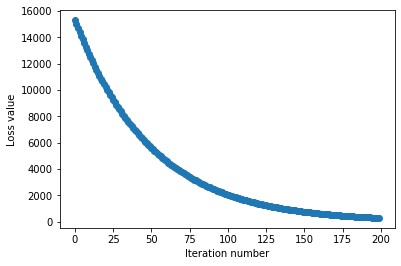

In [13]:
plt.plot(loss_hist, 'o')
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

## Prediction

Let's move on to the prediction stage.

In [14]:
def predict_linear_classifier(W, X):
  """
  Use the trained weights to predict labels for images.

  Inputs:
  - W: A PyTorch tensor of shape (D, K) containing the weights of a classifier.
  - X: A PyTorch tensor of shape (N, D) containing images for prediction.

  Returns:
  - y_pred: A PyTorch tensor of shape (N,) giving predicted labels.
    Each element of y_pred should be a 64-bit integer between 0 and K-1.
  """
  ###########################################################################
  # TODO:                                                                   #
  # Implement this method. Store the predicted labels in `y_pred`.          #
  ###########################################################################
  # Replace "pass" statement with your code
  y_pred = torch.max(X.mm(W), dim = 1)[1]
  # END OF YOUR CODE
  return y_pred

We can now evaluate the performance of our trained model on both the training set and the validation set. You should see prediction accuracy less than 20%.

In [15]:
y_train_pred = predict_linear_classifier(W, data_dict['X_train'])
train_acc = 100.0 * (data_dict['y_train'] == y_train_pred).float().mean().item()
print('training accuracy: %.2f%%' % train_acc)

y_val_pred = predict_linear_classifier(W, data_dict['X_val'])
val_acc = 100.0 * (data_dict['y_val'] == y_val_pred).float().mean().item()
print('validation accuracy: %.2f%%' % val_acc)

assert train_acc < 20
assert val_acc < 20

training accuracy: 9.70%
validation accuracy: 10.07%


## Cross Validation

Unfortunately, the performance of our initial model is quite bad. We need to find better hyperparamters. Before doing that, let us first put together the functions we've implemented.

In [16]:
class LinearClassifier:

  def __init__(self):
    self.W = None

  def train(self, X_train, y_train, learning_rate=1e-3, reg=1e-5, num_iters=100,
            batch_size=200, verbose=False):
    train_args = (self.loss, self.W, X_train, y_train, learning_rate, reg,
                  num_iters, batch_size, verbose)
    self.W, loss_history = train_linear_classifier(*train_args)
    return loss_history

  def predict(self, X):
    return predict_linear_classifier(self.W, X)

  def loss(self, W, X_batch, y_batch, reg):
    return softmax_loss_vectorized(W, X_batch, y_batch, reg)

Now, please use cross-validation to tune the hyperparameters (learning rate and regularization strength). You should experiment with different combinations of learning rates and regularization strengths. You may take a coarse-to-fine strategy, starting with a few initial combinations that coarsely cover a large range, then gradually narrowing down the range.

To get full credit, your best model found through cross-validation should achieve an accuracy of at least 39% on the validation set.

In [56]:
# Store your cross-validation results in this dictionary.
# The keys should be tuples of (learning_rate, regularization_strength) and
# the values should be tuples of (train_accuracy, val_accuracy).
results = {}

# Also, save your best trained classifer as a LinearClassifier object.
best_model = None

################################################################################
# TODO:                                                                        #
# Use cross-validation to tune the learning rate and regularization strength.  #
#                                                                              #
# You need to provide some candidate combinations of learning rate and         #
# regularization strength in your code. Then for each candidate combination,   #
# you need to train a classifier on the training set, compute its accuracy on  #
# both the training and validation sets, and store these numbers in the        #
# `results` dictionary. In addition, save your best trained classifer (the one #
# that achieves the best validation accuracy) in `best_model` (it should be a  #
# LinearClassifier object).                                                    #
#                                                                              #
# Hint: You should use a small value for `num_iters` as you develop your       #
# validation code so that the classifiers don't take much time to train;       #
# once you are confident that your validation code works, you should rerun the #
# validation code with a larger value for `num_iters` to ensure convergence.   #
# You may plot loss curves and print relevant information to monitor the       #
# training process.                                                            #
################################################################################
# Replace "pass" statement with your code
learning_rate = torch.tensor([1e-2, 2e-3, 3e-3, 4e-3, 5e-3])
reg = torch.tensor([5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-7, 5e-7])
val_acc_init = 0
for i in learning_rate:
  for j in reg:
    model = LinearClassifier()
    loss_hist = model.train(data_dict['X_train'], data_dict['y_train'], learning_rate=i, reg=j, num_iters=500,
            batch_size=200, verbose=False)
    y_train_pred = model.predict(data_dict['X_train'])
    train_acc = 100.0 * (data_dict['y_train'] == y_train_pred).float().mean().item()

    y_val_pred = model.predict(data_dict['X_val'])
    val_acc = 100.0 * (data_dict['y_val'] == y_val_pred).float().mean().item()
    results.update({(i.item(), j.item()): (train_acc, val_acc)})
    if val_acc > val_acc_init:
      best_model = model
      val_acc_init = val_acc
# END OF YOUR CODE

Run the following to visualize your cross-validation results:

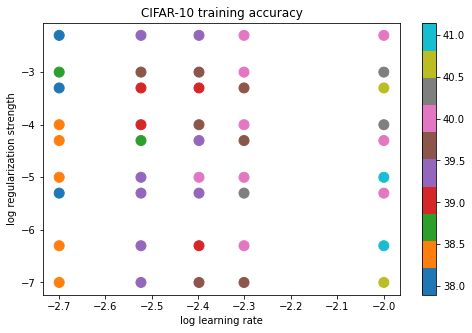

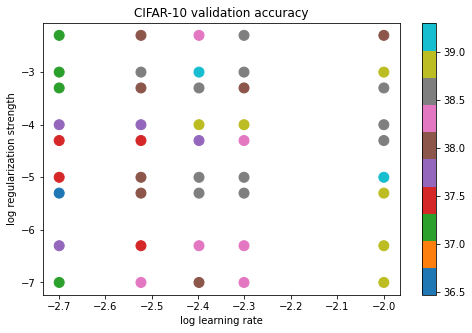

best validation accuracy: 39.30%


In [57]:
x_scatter = [math.log10(param[0]) for param in results]
y_scatter = [math.log10(param[1] + 1e-10) for param in results]

# Plot training accuracy
marker_size = 100
colors = [results[param][0] for param in results]
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap='tab10')
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')
plt.gcf().set_size_inches(8, 5)
plt.show()

# Plot validation accuracy
marker_size = 100
colors = [results[param][1] for param in results]
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap='tab10')
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.gcf().set_size_inches(8, 5)
plt.show()

# Print best validation accuracy
y_val_pred = best_model.predict(data_dict['X_val'])
val_acc = 100.0 * (data_dict['y_val'] == y_val_pred).float().mean().item()
print('best validation accuracy: %.2f%%' % val_acc)
assert val_acc >= 39

## Testing

Report the performance of your best model on the test set. This should be run only once.

In [58]:
y_test_pred = best_model.predict(data_dict['X_test'])
test_acc = 100.0 * (data_dict['y_test'] == y_test_pred).float().mean().item()
print('test accuracy: %.2f%%' % test_acc)

test accuracy: 39.10%


## Visualization

Finally, let's visualize the learned weights for each class.

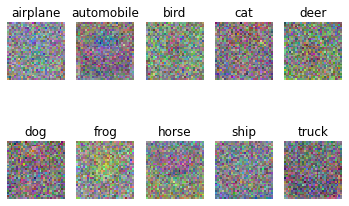

In [59]:
w = best_model.W[:-1]  # strip out the bias
w = w.reshape(3, 32, 32, 10)
w = w.permute(1, 2, 0, 3)

# Rescale the weights to be between 0 and 1
w_min = torch.amin(w, dim=(0,1,2), keepdim=True)
w_max = torch.amax(w, dim=(0,1,2), keepdim=True)
w_img = (w - w_min) / (w_max - w_min)
w_img = w_img.cpu()

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.imshow(w_img[..., i])
  plt.axis('off')
  plt.title(classes[i])